In [189]:
import data_analysis.data as data
import pandas as pd
import pulp
import itertools
import numpy as np
import time



# set depot latitude and longitude (Carron Place, Edinburgh)
depot_latitude = 55.972941
depot_longitude = -3.157436


# get names of all existing stations
october_data = data.load_data('10.csv')
october_data = october_data.drop(index=[5806,5853])
unique_stations = october_data.start_station_name.unique()

In [190]:

df_loc = pd.read_csv('loc_class.csv', delimiter=',', header=0)[['station_name', 'latitude', 'longitude','classification_3', 'cluster']]
df_loc.tail()

,station_name,latitude,longitude,classification_3,cluster
78,cluster 7,55.945037,-3.233172,supply,2
79,cluster 8,55.963431,-3.195992,demand,0
80,cluster 9,55.950426,-3.189278,supply,0
81,cluster 10,55.939540,-3.172835,demand,0
82,cluster 11,55.944840,-3.186214,leveled,0


In [191]:
len(df_loc)
region_1 = df_loc[df_loc.cluster == 0][['station_name','latitude', 'longitude','classification_3']].reset_index(drop=True)
region_2 = df_loc[df_loc.cluster == 1][['station_name','latitude', 'longitude','classification_3']].reset_index(drop=True)
region_3 = df_loc[df_loc.cluster == 2][['station_name','latitude', 'longitude','classification_3']].reset_index(drop=True)

region_2 = region_2#[region_3.classification_3 != 'leveled'].reset_index(drop=True)

region_2

,station_name,latitude,longitude,classification_3
0,EICC,55.946071,-3.210396,leveled
1,Haymarket Station,55.945569,-3.218185,supply
2,Meadow Place,55.940238,-3.194640,demand
3,Boroughmuir,55.940071,-3.215336,supply
4,South Trinity Road,55.971325,-3.207964,supply
5,Haymarket Terrace,55.946064,-3.223024,supply
6,Bruntsfield Links,55.937123,-3.206432,demand
7,Dundee Terrace,55.939710,-3.220589,supply
8,Tollcross,55.944248,-3.203105,demand
9,Gorgie Road,55.938741,-3.229909,supply


In [192]:
demand = pd.read_csv('demand_dec_01_02', delimiter=',', header=0)
demand= demand.drop('Unnamed: 0', axis=1)
demand.head()

# merge dataframes together
merged_1 = pd.merge(region_2, demand, on='station_name', how='left')
merged_1['demand'] = ''

#final = merged[merged.net_demand > 0].sort_values(by=['net_demand'], ascending=False).head(10).append(merged[merged.net_demand < 0].sort_values(by=['net_demand'], ascending=True).head(10))
for i in range(len(merged_1)):
    if merged_1.iloc[i,3] == 'demand':
        merged_1.iloc[i,6] = merged_1.iloc[i,4]
    else:
        merged_1.iloc[i,6] = merged_1.iloc[i,5]
        
merged_1 = merged_1.drop(['classification_3', 'Ht_new', 'TDt_new'], axis=1)[merged_1.demand != 0].reset_index(drop=True)
merged_1.index = merged_1.station_name


while merged_1[merged_1.demand > 0].demand.sum() > abs(-15 + merged_1[merged_1.demand < 0].demand.sum()):
    exclude = (merged_1[merged_1.demand > 0].sort_values(by='demand').head(1).iloc[0,0])
    merged_1 = merged_1.drop(exclude)



In [193]:

# add depot to top of the dataframe
depot = pd.DataFrame ({'station_name': 'depot', 'latitude': depot_latitude, 'longitude': depot_longitude, 'demand': 0}, index=[0])
df_loc = pd.concat([depot, merged_1]).reset_index(drop=True)

    
df_loc


,station_name,latitude,longitude,demand
0,depot,55.972941,-3.157436,0
1,South Trinity Road,55.971325,-3.207964,5
2,Tollcross,55.944248,-3.203105,-3
3,Inverleith Row,55.964118,-3.202095,6
4,Lauriston Place,55.944772,-3.197266,-6
5,Stockbridge,55.958566,-3.208070,4
6,Waitrose Comely Bank,55.959536,-3.223434,8


In [194]:
# before this stage the dataframe has to be reduced enough so that we only have to compute list of remaining 15-20 nodes
df_dist = pd.DataFrame(columns = ['station_1', 'station_2', 'distance'])
# calculate distances
for station_1 in df_loc['station_name']:
    for station_2 in df_loc['station_name']:
        lat_1 = df_loc[df_loc['station_name'] == station_1].iloc[0,1]
        long_1 = df_loc[df_loc['station_name'] == station_1].iloc[0,2]
        
        lat_2 = df_loc[df_loc['station_name'] == station_2].iloc[0,1]
        long_2 = df_loc[df_loc['station_name'] == station_2].iloc[0,2]
        
        dist = data.compute_distance(lat_1, long_1, lat_2, long_2)
        
        new_row = {'station_1': station_1, 'station_2': station_2, 'distance': dist}
        #append row to the dataframe
        df_dist = df_dist.append(new_row, ignore_index=True)

print(df_dist)
# calculate distance matrix

num_of_stations = len(df_dist['station_1'].unique())
print(num_of_stations)

dist_matrix = np.zeros((num_of_stations,num_of_stations))
for i in range(num_of_stations):
    for j in range(num_of_stations):
        dist_matrix[i][j] = df_dist.iloc[i*num_of_stations + j, 2]

dist_matrix

               station_1             station_2  distance
0                  depot                 depot  0.000000
1                  depot    South Trinity Road  3.150156
2                  depot             Tollcross  4.274541
3                  depot        Inverleith Row  2.948129
4                  depot       Lauriston Place  3.995979
5                  depot           Stockbridge  3.534540
6                  depot  Waitrose Comely Bank  4.370792
7     South Trinity Road                 depot  3.150156
8     South Trinity Road    South Trinity Road  0.000000
9     South Trinity Road             Tollcross  3.026966
10    South Trinity Road        Inverleith Row  0.881011
11    South Trinity Road       Lauriston Place  3.027749
12    South Trinity Road           Stockbridge  1.419287
13    South Trinity Road  Waitrose Comely Bank  1.627003
14             Tollcross                 depot  4.274541
15             Tollcross    South Trinity Road  3.026966
16             Tollcross       

array([[0.        , 3.15015638, 4.27454058, 2.94812947, 3.99597896,
        3.53454012, 4.37079237],
       [3.15015638, 0.        , 3.0269663 , 0.88101082, 3.027749  ,
        1.41928657, 1.62700285],
       [4.27454058, 3.0269663 , 0.        , 2.21101208, 0.36831855,
        1.62228369, 2.12005539],
       [2.94812947, 0.88101082, 2.21101208, 0.        , 2.17278657,
        0.72098389, 1.42299786],
       [3.99597896, 3.027749  , 0.36831855, 2.17278657, 0.        ,
        1.67535207, 2.31362375],
       [3.53454012, 1.41928657, 1.62228369, 0.72098389, 1.67535207,
        0.        , 0.96272368],
       [4.37079237, 1.62700285, 2.12005539, 1.42299786, 2.31362375,
        0.96272368, 0.        ]])

In [195]:
# Parameter initialisation

# the number of vehicles
vehicle_count = 1

# number of stations
station_count = len(df_dist['station_1'].unique())
print(station_count)

# vehicle capacity
vehicle_capacity = 15

7


In [196]:
# set up an optimisation model with pulp

t0 = time.process_time()
#time.sleep(1)
for vehicle_count in range(1,vehicle_count+1):
    
    # definition of LpProblem instance
    problem = pulp.LpProblem("bike_reallocation", pulp.LpMinimize)

    # definition of decision variables: x(1,j,k) 1 if vehicle k drives from i to j
    # exclude variables for driving to same station (unnecessary)
    x = [[[pulp.LpVariable("x%s_%s,%s"%(i,j,k), cat="Binary") if i != j else None for k in range(vehicle_count)]for j in range(station_count)] for i in range(station_count)]
    # flow of bikes variables: how many bikes are transported from i to j
    f = [[pulp.LpVariable("f%s_%s"%(i,j), cat="Continuous", lowBound = 0) if i != j else None for j in range(station_count)] for i in range(station_count)]
    # for subtour elimination
    u = [[pulp.LpVariable("u%s_%s"%(i,k), cat="Continuous", lowBound = 0) for k in range(vehicle_count)] for i in range(station_count)]
    
    
    # objective function: distance as a first measure of cost
    problem += pulp.lpSum(dist_matrix[i][j] * x[i][j][k] + 0.01 * f[i][j] * dist_matrix[i][j] if i != j else 0
                          for k in range(vehicle_count) 
                          for j in range(station_count) 
                          for i in range(station_count))

    # constraints
    # only one visit per vehicle per bike station
    for j in range(1, station_count):
        problem += pulp.lpSum(x[i][j][k] if i != j else 0 
                              for i in range(station_count) 
                              for k in range(vehicle_count)) == 1 

    # exactly one departure and one arrival from depot/back to depot per vehicle 
    for k in range(vehicle_count):
        problem += pulp.lpSum(x[0][j][k] for j in range(1,station_count)) == 1
        problem += pulp.lpSum(x[i][0][k] for i in range(1,station_count)) == 1

    # flow constraint: if vehicle drives to node it also has to leave it
    for k in range(vehicle_count):
        for j in range(station_count):
            problem += pulp.lpSum(x[i][j][k] if i != j else 0 
                                  for i in range(station_count)) -  pulp.lpSum(x[j][i][k] for i in range(station_count)) == 0

    
    
    # flow of bikes varies according to demand at every node
    # negative demand implies that bikes have to be picked up
    for i in range(1, station_count):
        problem += pulp.lpSum(f[j][i] for j in range(station_count)) - pulp.lpSum(f[i][j] for j in range(station_count)) == df_loc.demand[i]
    
    # flow of bikes between two stations cannot exceed vehicle capacity
    for i in range(station_count):
        for j in range(station_count):
            problem += f[i][j] <= vehicle_capacity * pulp.lpSum(x[i][j][k] if i != j else 0 for k in range(vehicle_count))
    
    # flow of bikes between two stations cannot be negative
    for i in range(station_count):
        for j in range(station_count):
            if i != j:
                problem += f[i][j] >= 0
                
    # subtour elimination constraint :Desrochers-Laporte formulation
    for k in range(vehicle_count):
        for i in range(1,station_count):
            for j in range(1,station_count):
                if i != j:
                    problem += u[i][k] - u[j][k] + (station_count - 1) * x[i][j][k] + (station_count - 3) * x[j][i][k] <= station_count - 2
                

    for i in range(1,station_count):
        problem += u[i][k] <= station_count - 1 
        problem += u[i][k] >= 1
    
    # constraint for the removal of subtours
    #subtours = []
    #for i in range(2,station_count):
     #    subtours += itertools.combinations(range(1,station_count), i)

   # for s in subtours:
      #  problem += pulp.lpSum(x[i][j][k] if i !=j else 0 for i, j in itertools.permutations(s,2) for k in range(vehicle_count)) <= len(s) - 1

    
    # print vehicle_count which is needed for solving the problem
    # print calculated minimum distance value
    if problem.solve() == 1:

        print('Vehicle Requirements:', vehicle_count)
        print('cost approx:', pulp.value(problem.objective))
        for i in range(station_count):
            for j in range(station_count):
                for k in range(vehicle_count):
                    if i!=j and pulp.value(x[i][j][k]) != 0:
                        print(f'bikes transported from {df_loc.station_name[i]} to {df_loc.station_name[j]}', pulp.value(f[i][j]))
                        
        break
    else:
        print('not solved to optimality')
     
t1 = time.process_time() - t0
print("Time elapsed: ", t1)
   

Vehicle Requirements: 1
cost approx: 13.44417828339995
bikes transported from depot to South Trinity Road 14.0
bikes transported from South Trinity Road to Waitrose Comely Bank 9.0
bikes transported from Tollcross to Lauriston Place 4.0
bikes transported from Inverleith Row to depot 0.0
bikes transported from Lauriston Place to Stockbridge 10.0
bikes transported from Stockbridge to Inverleith Row 6.0
bikes transported from Waitrose Comely Bank to Tollcross 1.0
Time elapsed:  0.03125


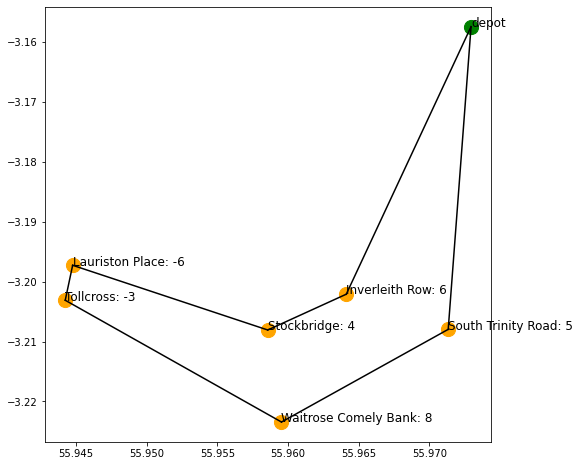

In [197]:
# visualization : plotting with matplolib
import matplotlib.pyplot as plt

plt.figure(figsize=(8,8))
for i in range(station_count):    
    if i == 0:
        plt.scatter(df_loc.latitude[i], df_loc.longitude[i], c='green', s=200)
        plt.text(df_loc.latitude[i], df_loc.longitude[i], "depot", fontsize=12)
    else:
        plt.scatter(df_loc.latitude[i], df_loc.longitude[i], c='orange', s=200)
        plt.text(df_loc.latitude[i], df_loc.longitude[i], str(df_loc.station_name[i]) + ': ' + str(int(df_loc.demand[i])), fontsize=12)

for k in range(vehicle_count):
    for i in range(station_count):
        for j in range(station_count):
            if i != j and pulp.value(x[i][j][k]) == 1:
                plt.plot([df_loc.latitude[i], df_loc.latitude[j]], [df_loc.longitude[i], df_loc.longitude[j]], c="black")

plt.show()